In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from datetime import datetime


In [24]:
preis_bis_2015 = pd.read_csv("Gro_handelspreise_201501010000_201810010000_Stunde.csv", sep=";")
preis_ab_2015 = pd.read_csv("Gro_handelspreise_201809300000_202501010000_Stunde.csv", sep=";")

In [25]:
# Process preis_bis_2015 and preis_ab_2015
# Convert dates to datetime
preis_bis_2015['Datum von'] = pd.to_datetime(preis_bis_2015['Datum von'], format='%d.%m.%Y %H:%M')
preis_ab_2015['Datum von'] = pd.to_datetime(preis_ab_2015['Datum von'], format='%d.%m.%Y %H:%M')

# Select relevant columns and merge
df1 = preis_bis_2015[['Datum von', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen', 'DE/AT/LU [€/MWh] Originalauflösungen']]
df2 = preis_ab_2015[['Datum von', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen']]

# Combine the price columns into one
df1['combined_price'] = df1.apply(
    lambda x: x['DE/AT/LU [€/MWh] Originalauflösungen'] if x['Deutschland/Luxemburg [€/MWh] Originalauflösungen'] == '-' 
    else x['Deutschland/Luxemburg [€/MWh] Originalauflösungen'], axis=1
)

# Create final dataframes with just date and price
df1_final = df1[['Datum von', 'combined_price']].rename(columns={'combined_price': 'price'})
df2_final = df2[['Datum von', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen']].rename(
    columns={'Deutschland/Luxemburg [€/MWh] Originalauflösungen': 'price'}
)

# Concatenate the dataframes
preis = pd.concat([df1_final, df2_final], ignore_index=True)

# Sort by date
preis = preis.sort_values('Datum von').reset_index(drop=True)

# Clean up the price column (replace commas with dots and convert to float)
preis['price'] = preis['price'].replace('-', '0').str.replace(',', '.').astype(float)

C:\Users\TimPr\AppData\Local\Temp\ipykernel_30288\431591383.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['combined_price'] = df1.apply(


In [28]:
pd.to_csv(preis, 'preis.csv')

AttributeError: module 'pandas' has no attribute 'to_csv'

In [4]:
verbrauch = pd.read_csv('Realisierter_Stromverbrauch_201501010000_202412020000_Viertelstunde.csv',sep=';')
erzeugung = pd.read_csv('Realisierte_Erzeugung_201501010000_202412020000_Viertelstunde.csv',sep=';')
preis = pd.read_csv('Gro_handelspreise_201501010000_202412020000_Stunde.csv',sep=';')


In [5]:
# First, let's process the timestamps in the dataframes
for df in [verbrauch, erzeugung, preis]:
    df['Datum von'] = pd.to_datetime(df['Datum von'], format='%d.%m.%Y %H:%M')
    df['Datum bis'] = pd.to_datetime(df['Datum bis'], format='%d.%m.%Y %H:%M')

# Resample preis to 15-minute intervals to match other dataframes
preis_resampled = preis.drop_duplicates(subset='Datum von').set_index('Datum von').resample('15T').ffill().reset_index()

# Merge the dataframes on 'Datum von'
combined_df = verbrauch.merge(erzeugung, on=['Datum von', 'Datum bis'], how='outer')
combined_df = combined_df.merge(preis_resampled[['Datum von', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen']], 
                              on='Datum von', 
                              how='outer')

# Clean up numeric columns by removing thousand separators and converting to float
numeric_columns = combined_df.select_dtypes(include=['object']).columns
for col in numeric_columns:
    if col not in ['Datum von', 'Datum bis']:
        # Replace '-' with NaN and convert to float
        combined_df[col] = combined_df[col].str.replace('.', '').str.replace(',', '.').replace('-', np.nan).astype(float)
        combined_df[col] = combined_df[col].ffill()

C:\Users\TimPr\AppData\Local\Temp\ipykernel_30288\3171798497.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  preis_resampled = preis.drop_duplicates(subset='Datum von').set_index('Datum von').resample('15T').ffill().reset_index()


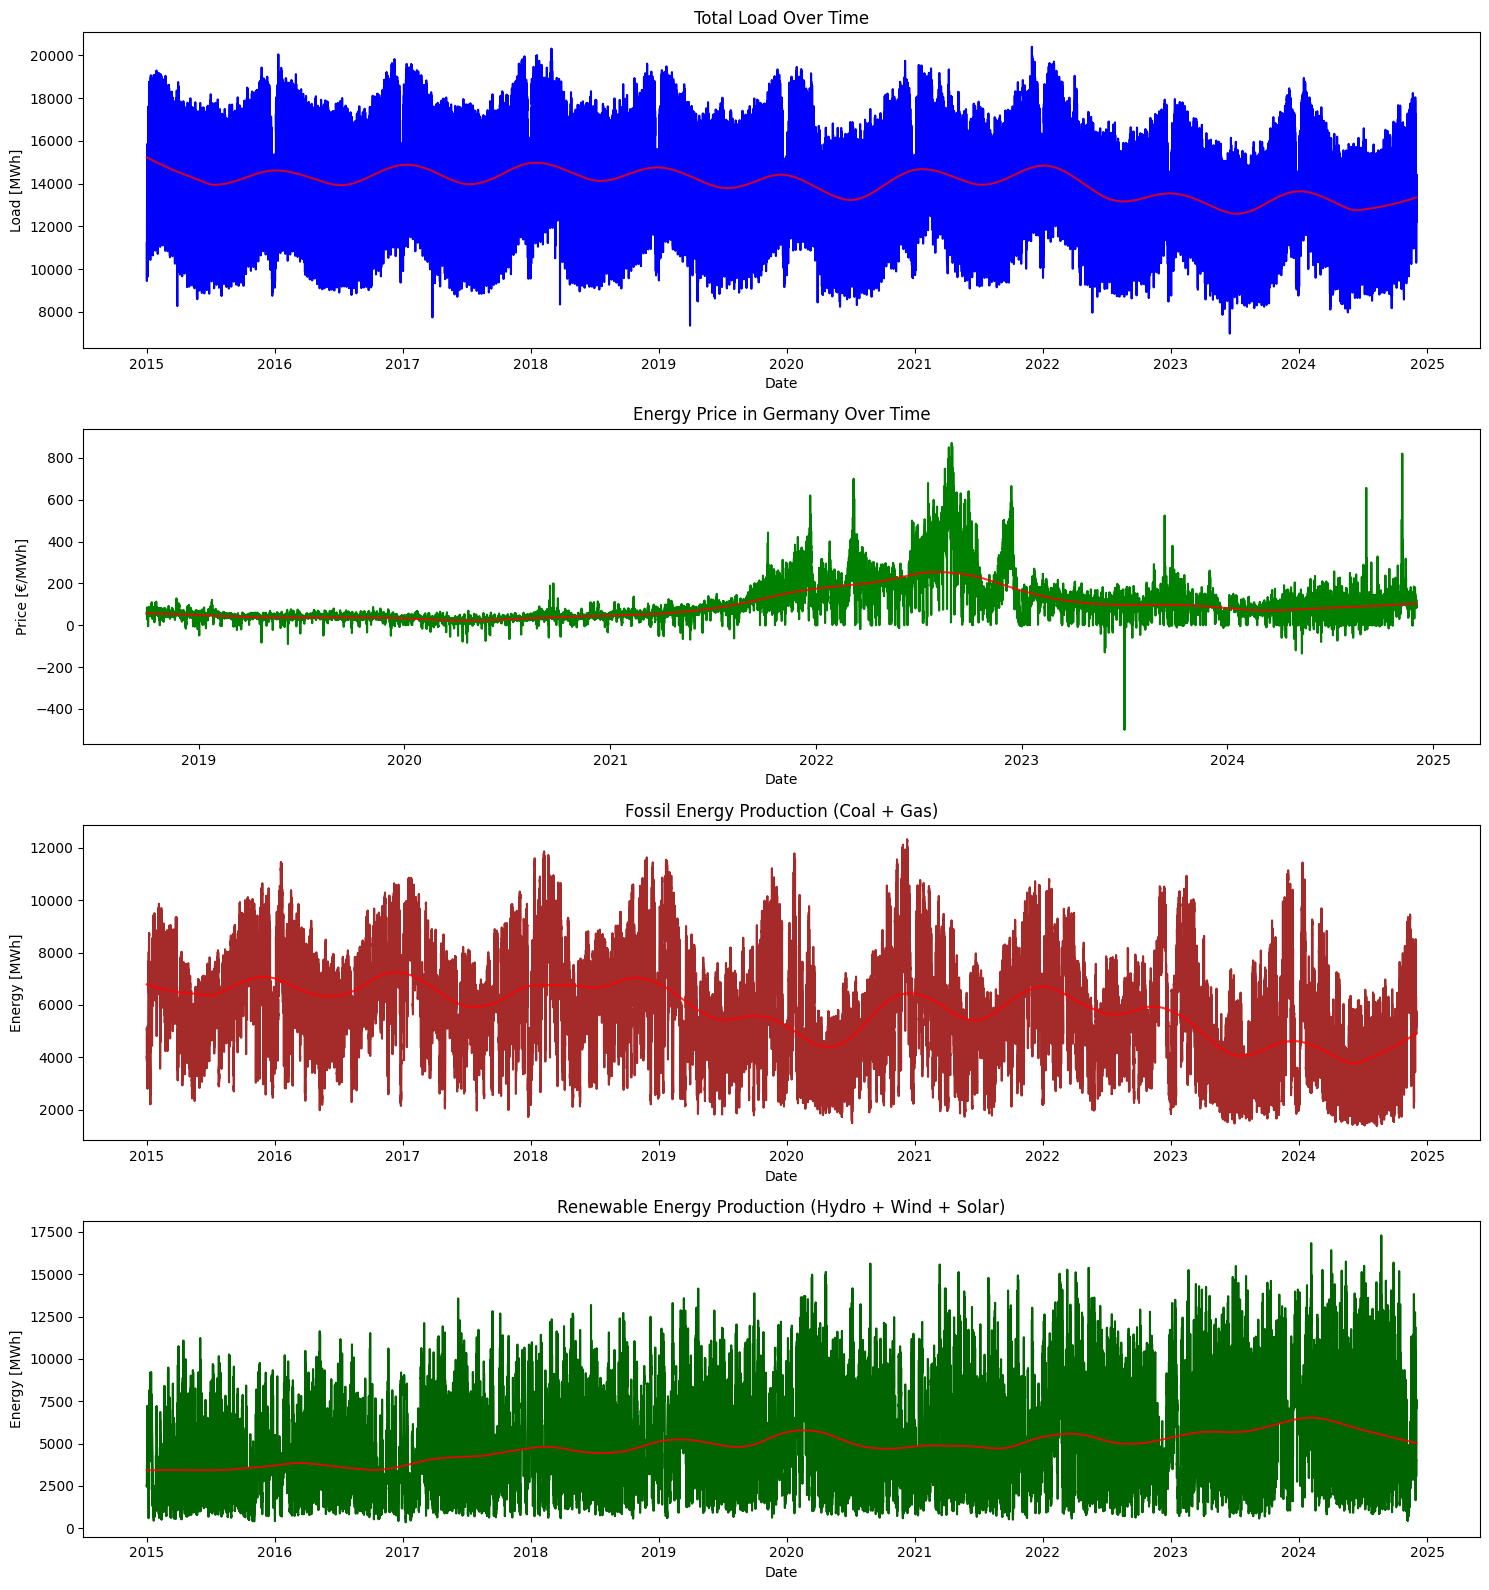

In [6]:
# Downsample factor (e.g., 10 for taking every 10th point)
downsample_factor = 10

# Downsampled indices
downsampled_indices = np.arange(0, len(combined_df), downsample_factor)

# Create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 16))

# Plot 1: Load over time (blue)
ax1.plot(combined_df['Datum von'], combined_df['Gesamt (Netzlast) [MWh] Originalauflösungen'], color='blue')
ax1.set_title('Total Load Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Load [MWh]')
trend1 = lowess(
    combined_df['Gesamt (Netzlast) [MWh] Originalauflösungen'][downsampled_indices], 
    downsampled_indices, 
    frac=0.1
)
ax1.plot(combined_df['Datum von'][downsampled_indices], trend1[:, 1], "r-", alpha=0.8)

# Plot 2: Energy price in Germany (green)
valid_prices = combined_df['Deutschland/Luxemburg [€/MWh] Originalauflösungen'].dropna()
valid_dates = combined_df['Datum von'][valid_prices.index]
downsampled_indices_prices = np.arange(0, len(valid_prices), downsample_factor)
ax2.plot(combined_df['Datum von'], combined_df['Deutschland/Luxemburg [€/MWh] Originalauflösungen'], color='green')
ax2.set_title('Energy Price in Germany Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price [€/MWh]')
trend2 = lowess(
    valid_prices.iloc[downsampled_indices_prices], 
    downsampled_indices_prices, 
    frac=0.1
)
ax2.plot(valid_dates.iloc[downsampled_indices_prices], trend2[:, 1], "r-", alpha=0.8)

# Plot 3: Fossil Energy (brown)
fossil = (combined_df['Braunkohle [MWh] Originalauflösungen'] + 
          combined_df['Erdgas [MWh] Originalauflösungen'] + 
          combined_df['Steinkohle [MWh] Originalauflösungen'])
ax3.plot(combined_df['Datum von'], fossil, color='brown')
ax3.set_title('Fossil Energy Production (Coal + Gas)')
ax3.set_xlabel('Date')
ax3.set_ylabel('Energy [MWh]')
trend3 = lowess(
    fossil[downsampled_indices], 
    downsampled_indices, 
    frac=0.1
)
ax3.plot(combined_df['Datum von'][downsampled_indices], trend3[:, 1], "r-", alpha=0.8)

# Plot 4: Renewable Energy (green)
renewable = (combined_df['Wasserkraft [MWh] Originalauflösungen'] + 
            combined_df['Wind Offshore [MWh] Originalauflösungen'] + 
            combined_df['Wind Onshore [MWh] Originalauflösungen'] + 
            combined_df['Photovoltaik [MWh] Originalauflösungen'])
ax4.plot(combined_df['Datum von'], renewable, color='darkgreen')
ax4.set_title('Renewable Energy Production (Hydro + Wind + Solar)')
ax4.set_xlabel('Date')
ax4.set_ylabel('Energy [MWh]')
trend4 = lowess(
    renewable[downsampled_indices], 
    downsampled_indices, 
    frac=0.1
)
ax4.plot(combined_df['Datum von'][downsampled_indices], trend4[:, 1], "r-", alpha=0.8)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\TimPr\AppData\Local\Temp\ipykernel_30288\1370569671.py:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.resample('Y')[columns_of_interest].sum()


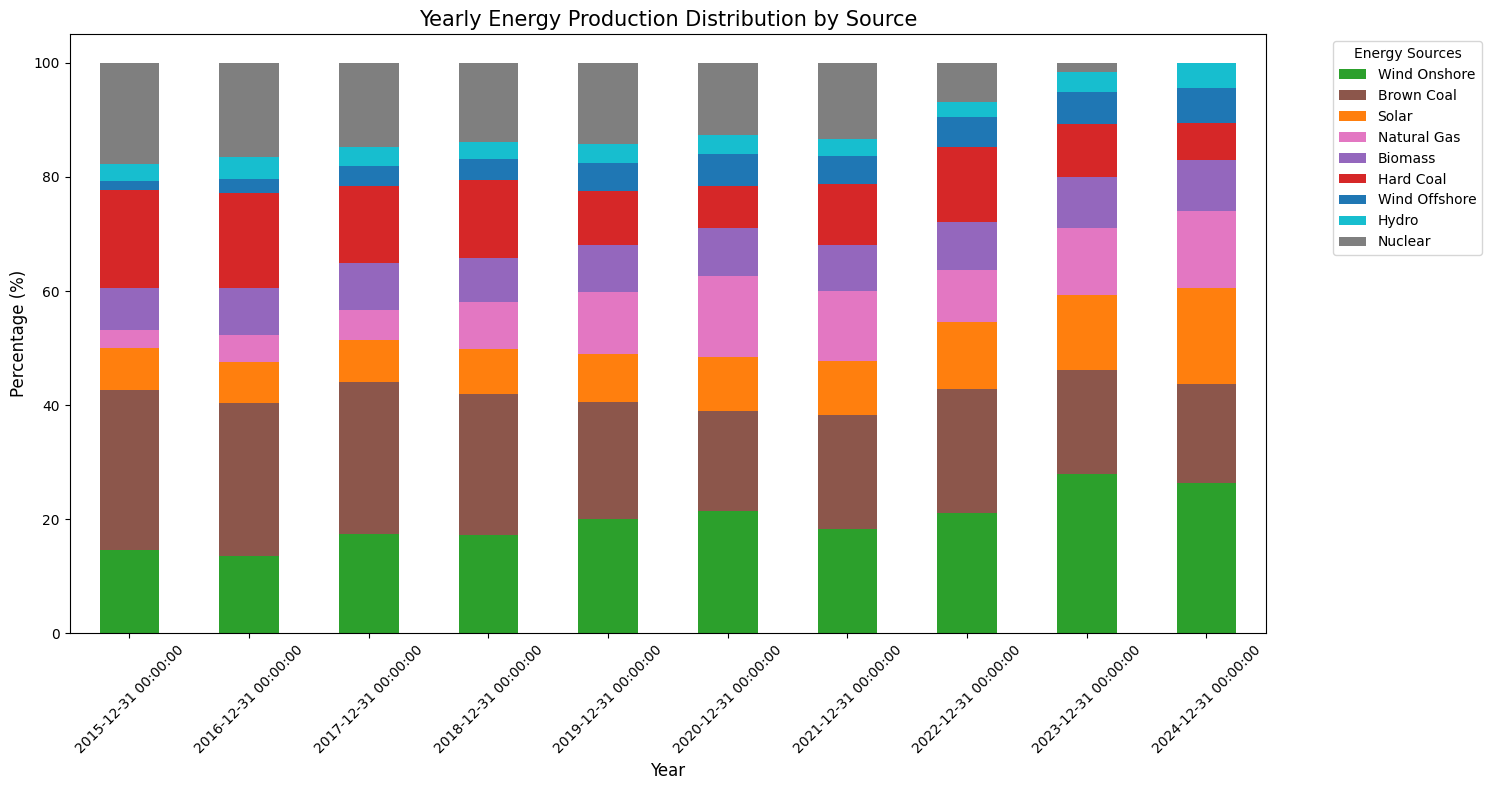


Percentage Distribution of Energy Production (sorted by percentage):
       Source  Percentage
 Wind Onshore        25.8
   Braunkohle        16.9
 Photovoltaik        16.3
       Erdgas        13.2
     Biomasse         8.7
   Steinkohle         6.4
Wind Offshore         6.1
  Wasserkraft         4.2
 Pumpspeicher         2.5
  Kernenergie         0.0


In [8]:
# Create a copy of the dataframe with datetime index
df = combined_df.copy()
df.set_index('Datum von', inplace=True)

# Define columns of interest
columns_of_interest = [
    'Wind Onshore [MWh] Originalauflösungen',
    'Braunkohle [MWh] Originalauflösungen',
    'Photovoltaik [MWh] Originalauflösungen',
    'Erdgas [MWh] Originalauflösungen',
    'Biomasse [MWh] Originalauflösungen',
    'Steinkohle [MWh] Originalauflösungen',
    'Wind Offshore [MWh] Originalauflösungen',
    'Wasserkraft [MWh] Originalauflösungen',
    'Kernenergie [MWh] Originalauflösungen'
]

# Resample the data to yearly frequency, summing up the production for each energy source
df_yearly = df.resample('Y')[columns_of_interest].sum()

# Calculate the total production for each year
df_yearly['Total'] = df_yearly.sum(axis=1)

# Calculate the percentage contribution of each energy source to the total production
df_percentage = df_yearly[columns_of_interest].div(df_yearly['Total'], axis=0) * 100

# Define the desired order of energy sources
desired_order = [
    'Wind Onshore [MWh] Originalauflösungen',
    'Braunkohle [MWh] Originalauflösungen',
    'Photovoltaik [MWh] Originalauflösungen',
    'Erdgas [MWh] Originalauflösungen',
    'Biomasse [MWh] Originalauflösungen',
    'Steinkohle [MWh] Originalauflösungen',
    'Wind Offshore [MWh] Originalauflösungen',
    'Wasserkraft [MWh] Originalauflösungen',
    'Kernenergie [MWh] Originalauflösungen'
]

# Reorder the columns in df_percentage
df_percentage = df_percentage[desired_order]

# Adjust colors to match the type of production
colors = [
    '#2ca02c',  # Wind Onshore - green for renewable
    '#8c564b',  # Braunkohle (Brown Coal) - brown
    '#ff7f0e',  # Photovoltaik (Solar) - orange for sunlight
    '#e377c2',  # Erdgas (Natural Gas) - pinkish for gas
    '#9467bd',  # Biomasse (Biomass) - purple
    '#d62728',  # Steinkohle (Hard Coal) - dark red
    '#1f77b4',  # Wind Offshore - blue for wind and sea
    '#17becf',  # Wasserkraft (Hydro) - light blue for water
    '#7f7f7f'   # Kernenergie (Nuclear) - neutral grey
]

# Create the bar plot
ax = df_percentage.plot(kind='bar', stacked=True, figsize=(15, 8), color=colors)

plt.title('Yearly Energy Production Distribution by Source', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)

# Simplify the legend labels to match the order
legend_labels = [
    'Wind Onshore', 'Brown Coal', 'Solar', 'Natural Gas', 'Biomass',
    'Hard Coal', 'Wind Offshore', 'Hydro', 'Nuclear'
]
plt.legend(title='Energy Sources', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Get the data for 2024
df_2024 = combined_df[combined_df['Datum von'].dt.year == 2024]

# Create dictionary of production sources
production_sources = {
    'Wind Offshore': df_2024['Wind Offshore [MWh] Originalauflösungen'].sum(),
    'Wind Onshore': df_2024['Wind Onshore [MWh] Originalauflösungen'].sum(),
    'Photovoltaik': df_2024['Photovoltaik [MWh] Originalauflösungen'].sum(),
    'Wasserkraft': df_2024['Wasserkraft [MWh] Originalauflösungen'].sum(),
    'Biomasse': df_2024['Biomasse [MWh] Originalauflösungen'].sum(),
    'Kernenergie': df_2024['Kernenergie [MWh] Originalauflösungen'].sum(),
    'Braunkohle': df_2024['Braunkohle [MWh] Originalauflösungen'].sum(),
    'Steinkohle': df_2024['Steinkohle [MWh] Originalauflösungen'].sum(),
    'Erdgas': df_2024['Erdgas [MWh] Originalauflösungen'].sum(),
    'Pumpspeicher': df_2024['Pumpspeicher [MWh] Originalauflösungen_y'].sum()
}

# Create DataFrame from production sources
production_df = pd.DataFrame(list(production_sources.items()), columns=['Source', 'Total Production (MWh)'])

# Calculate total production
total_production = sum(production_sources.values())

# Convert to DataFrame with percentages
production_df_pct = production_df.copy()
production_df_pct['Percentage'] = (production_df_pct['Total Production (MWh)'] / total_production * 100)


# Sort the DataFrame by percentage in descending order and display
print("\nPercentage Distribution of Energy Production (sorted by percentage):")
print(production_df_pct.sort_values('Percentage', ascending=False)[['Source', 'Percentage']].to_string(index=False, float_format=lambda x: '{:.1f}'.format(x)))


When do we need energy and how much?

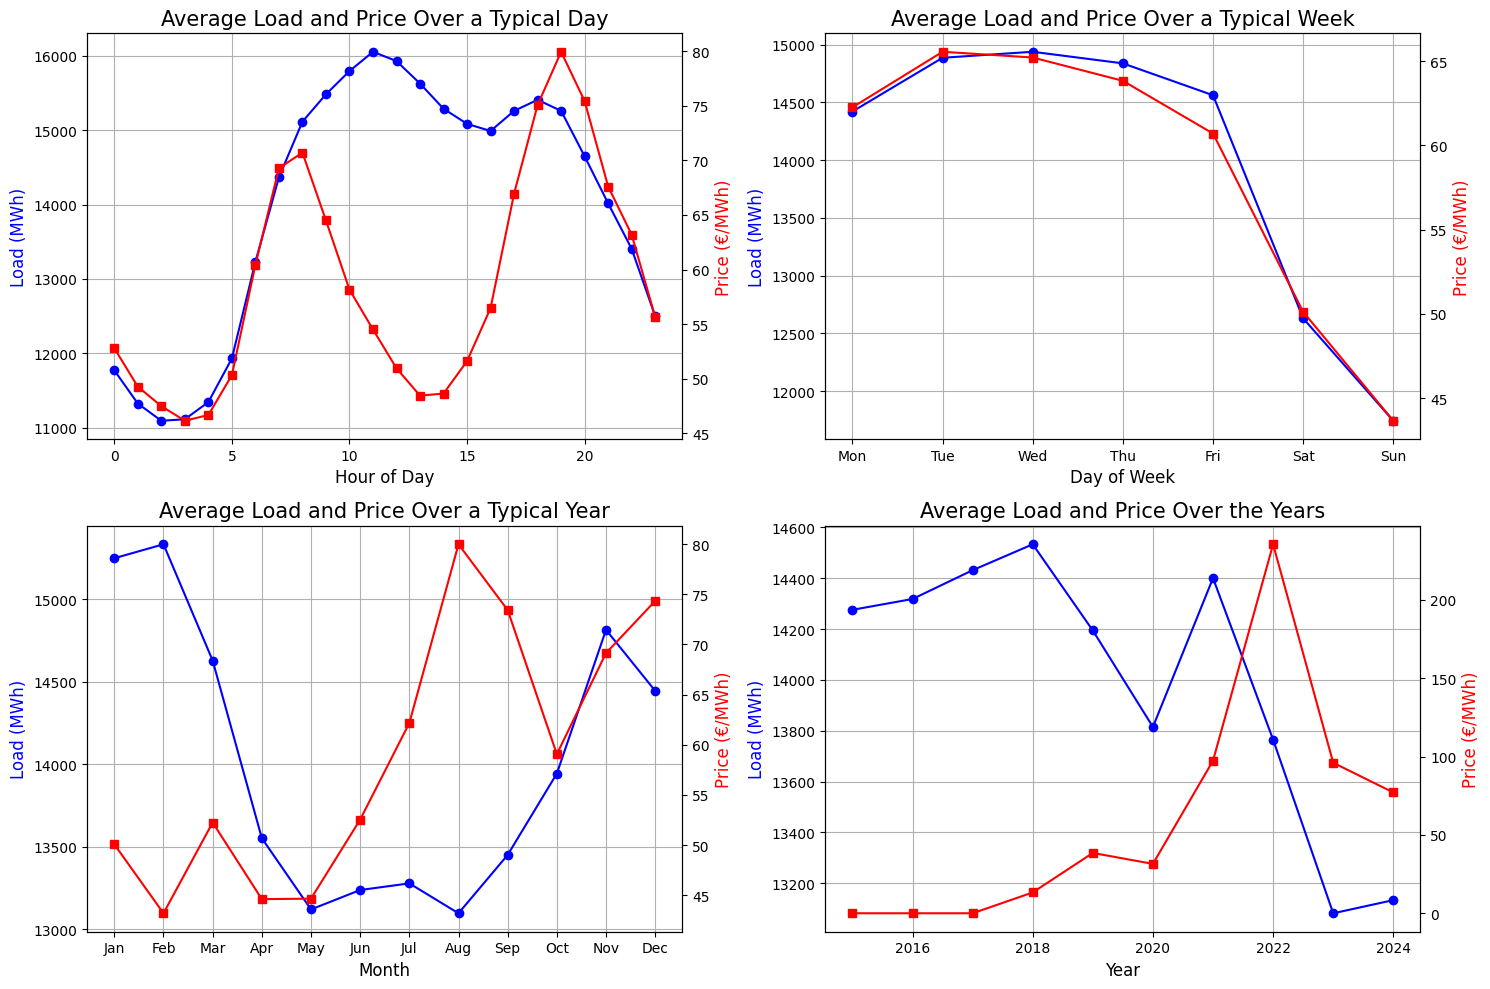

In [16]:
# Use the verbrauch dataframe we loaded earlier
df = verbrauch.copy()

# Preprocessing
df['Datum von'] = pd.to_datetime(df['Datum von'], format='%d.%m.%Y %H:%M')
df['Gesamt (Netzlast) [MWh] Originalauflösungen'] = df['Gesamt (Netzlast) [MWh] Originalauflösungen'].str.replace('.', '').str.replace(',', '.').astype(float)

# Rename column for simplicity
df.rename(columns={'Gesamt (Netzlast) [MWh] Originalauflösungen': 'Netzlast'}, inplace=True)

# Add price data
df = df.merge(preis_resampled[['Datum von', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen']], 
              on='Datum von', 
              how='left')
df['Deutschland/Luxemburg [€/MWh] Originalauflösungen'] = df['Deutschland/Luxemburg [€/MWh] Originalauflösungen'].str.replace('-', '0').str.replace(',', '.').astype(float)

# Extract relevant features
df['Hour'] = df['Datum von'].dt.hour
df['Month'] = df['Datum von'].dt.month
df['Year'] = df['Datum von'].dt.year
df['DayOfWeek'] = df['Datum von'].dt.dayofweek
df['DayOfMonth'] = df['Datum von'].dt.day

# Group for averages
daily_avg_load = df.groupby('Hour')['Netzlast'].mean()
daily_avg_price = df.groupby('Hour')['Deutschland/Luxemburg [€/MWh] Originalauflösungen'].mean()

weekly_avg_load = df.groupby('DayOfWeek')['Netzlast'].mean()
weekly_avg_price = df.groupby('DayOfWeek')['Deutschland/Luxemburg [€/MWh] Originalauflösungen'].mean()

monthly_avg_load = df.groupby('Month')['Netzlast'].mean()
monthly_avg_price = df.groupby('Month')['Deutschland/Luxemburg [€/MWh] Originalauflösungen'].mean()

yearly_avg_load = df.groupby('Year')['Netzlast'].mean()
yearly_avg_price = df.groupby('Year')['Deutschland/Luxemburg [€/MWh] Originalauflösungen'].mean()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Daily pattern
ax1 = axes[0, 0]
ax1_twin = ax1.twinx()

ax1.plot(daily_avg_load.index, daily_avg_load, marker='o', color='b', label='Load')
ax1_twin.plot(daily_avg_price.index, daily_avg_price, marker='s', color='r', label='Price')

ax1.set_title('Average Load and Price Over a Typical Day', fontsize=15)
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Load (MWh)', color='b', fontsize=12)
ax1_twin.set_ylabel('Price (€/MWh)', color='r', fontsize=12)
ax1.grid()

# Plot 2: Weekly pattern
ax2 = axes[0, 1]
ax2_twin = ax2.twinx()

ax2.plot(weekly_avg_load.index, weekly_avg_load, marker='o', color='b', label='Load')
ax2_twin.plot(weekly_avg_price.index, weekly_avg_price, marker='s', color='r', label='Price')

ax2.set_title('Average Load and Price Over a Typical Week', fontsize=15)
ax2.set_xlabel('Day of Week', fontsize=12)
ax2.set_ylabel('Load (MWh)', color='b', fontsize=12)
ax2_twin.set_ylabel('Price (€/MWh)', color='r', fontsize=12)
ax2.set_xticks(range(7))
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax2.grid()

# Plot 3: Monthly pattern
ax3 = axes[1, 0]
ax3_twin = ax3.twinx()

ax3.plot(monthly_avg_load.index, monthly_avg_load, marker='o', color='b', label='Load')
ax3_twin.plot(monthly_avg_price.index, monthly_avg_price, marker='s', color='r', label='Price')

ax3.set_title('Average Load and Price Over a Typical Year', fontsize=15)
ax3.set_xlabel('Month', fontsize=12)
ax3.set_ylabel('Load (MWh)', color='b', fontsize=12)
ax3_twin.set_ylabel('Price (€/MWh)', color='r', fontsize=12)
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax3.grid()

# Plot 4: Yearly trend
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()

ax4.plot(yearly_avg_load.index, yearly_avg_load, marker='o', color='b', label='Load')
ax4_twin.plot(yearly_avg_price.index, yearly_avg_price, marker='s', color='r', label='Price')

ax4.set_title('Average Load and Price Over the Years', fontsize=15)
ax4.set_xlabel('Year', fontsize=12)
ax4.set_ylabel('Load (MWh)', color='b', fontsize=12)
ax4_twin.set_ylabel('Price (€/MWh)', color='r', fontsize=12)
ax4.grid()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


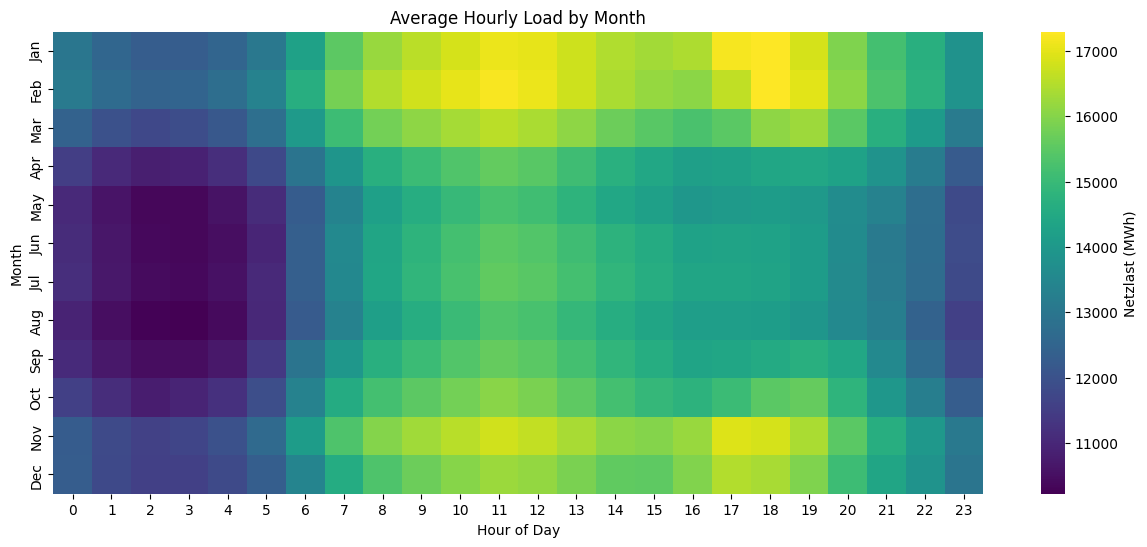

In [12]:
# Extract hour from datetime and create pivot table for monthly-hourly averages
combined_df['Hour'] = combined_df['Datum von'].dt.hour
combined_df['Month'] = combined_df['Datum von'].dt.month

hourly_monthly_avg = combined_df.pivot_table(
    values='Gesamt (Netzlast) [MWh] Originalauflösungen', 
    index='Hour',
    columns='Month',
    aggfunc='mean'
)

# Create heatmap with switched axes
plt.figure(figsize=(15, 6))
sns.heatmap(hourly_monthly_avg.T, 
            cmap='viridis',
            annot=False,
            cbar_kws={'label': 'Netzlast (MWh)'},
            yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.title('Average Hourly Load by Month')
plt.ylabel('Month')
plt.xlabel('Hour of Day')
plt.show()


How much do we produce and when?

In [13]:
# Define the columns of interest
columns_of_interest = [
    'Wind Offshore [MWh] Originalauflösungen',
    'Wind Onshore [MWh] Originalauflösungen',
    'Photovoltaik [MWh] Originalauflösungen',
    'Wasserkraft [MWh] Originalauflösungen',
    'Biomasse [MWh] Originalauflösungen',
    'Kernenergie [MWh] Originalauflösungen',
    'Braunkohle [MWh] Originalauflösungen',
    'Steinkohle [MWh] Originalauflösungen',
    'Erdgas [MWh] Originalauflösungen'
]

# Create a copy of the dataframe with datetime index
df = combined_df.copy()
df.set_index('Datum von', inplace=True)

# Resample the data to yearly frequency, summing up the production for each energy source
df_yearly = df.resample('Y')[columns_of_interest].sum()

# Calculate the total production for each year
df_yearly['Total'] = df_yearly.sum(axis=1)

# Calculate the percentage contribution of each energy source to the total production
df_percentage = df_yearly[columns_of_interest].div(df_yearly['Total'], axis=0) * 100



C:\Users\TimPr\AppData\Local\Temp\ipykernel_30288\4042665287.py:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.resample('Y')[columns_of_interest].sum()


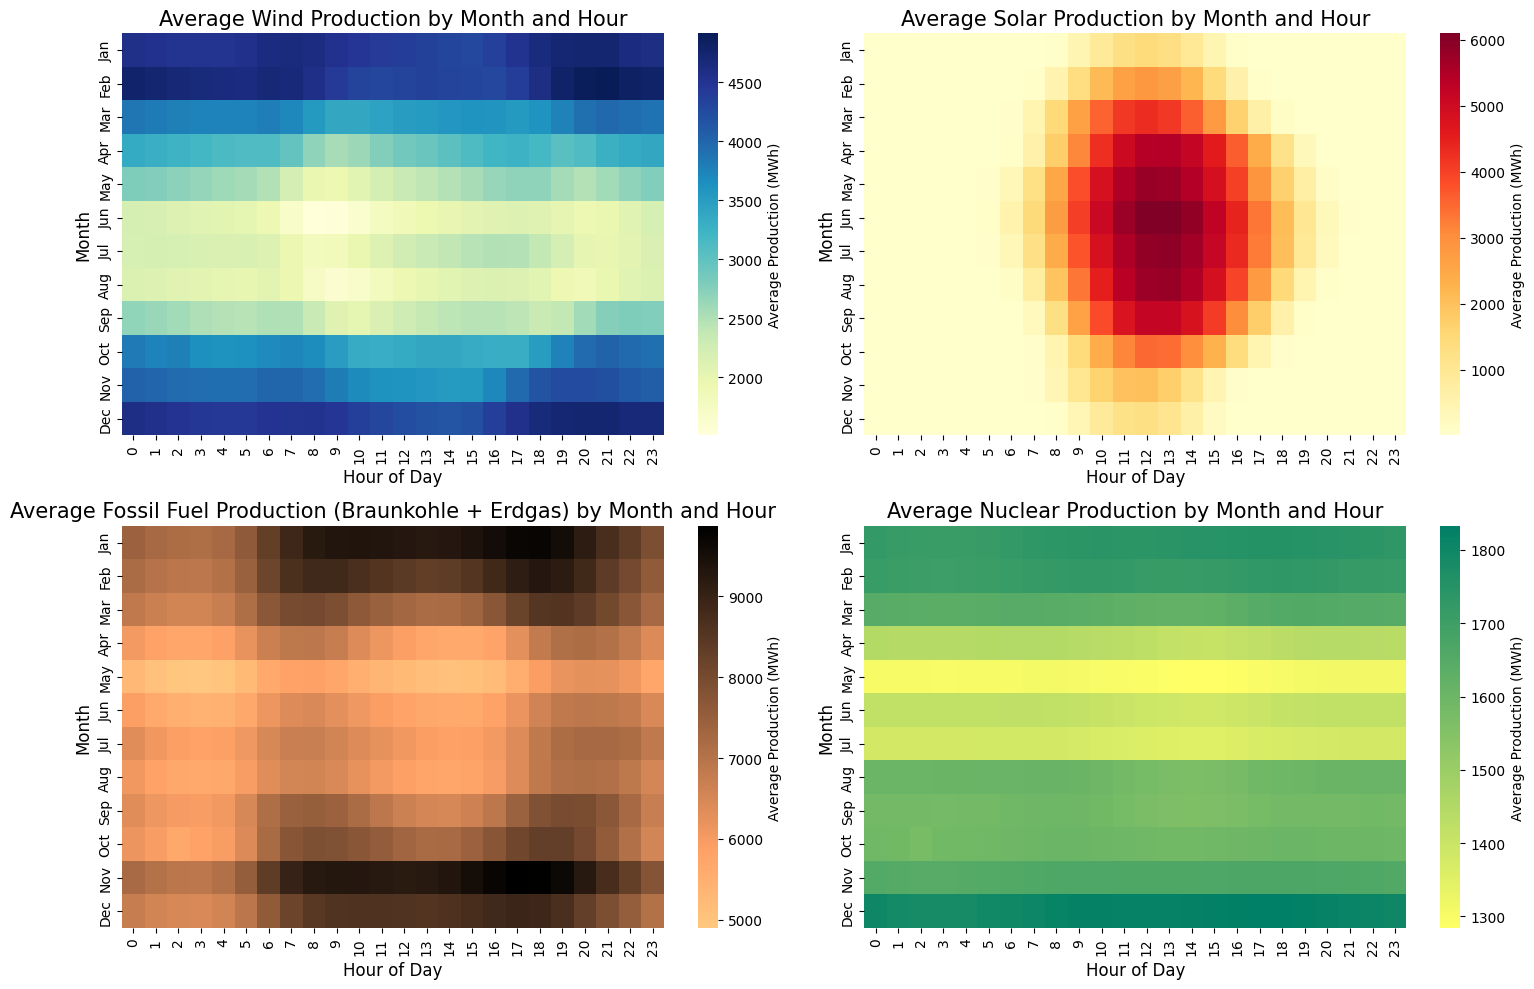

In [19]:
# Define a function to create and plot heatmaps in subplots
def plot_heatmap_subplot(ax, df, value_col, title, cmap):
    pivot = pd.pivot_table(
        data=df,
        values=value_col,
        index='Month',
        columns='Hour',
        aggfunc='mean'
    )
    sns.heatmap(
        pivot,
        cmap=cmap,
        cbar_kws={'label': 'Average Production (MWh)'},
        xticklabels=range(24),
        yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        ax=ax
    )
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Month', fontsize=12)

# Create subplots (2x2 grid)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Calculate total wind and fossil production
combined_df['Total Wind [MWh]'] = (combined_df['Wind Offshore [MWh] Originalauflösungen'] + 
                                  combined_df['Wind Onshore [MWh] Originalauflösungen'])
combined_df['Total Fossil [MWh]'] = (combined_df['Braunkohle [MWh] Originalauflösungen'] + 
                                    combined_df['Erdgas [MWh] Originalauflösungen'] +
                                    combined_df['Steinkohle [MWh] Originalauflösungen'] +
                                    combined_df['Erdgas [MWh] Originalauflösungen'])

# Create and plot heatmaps for Wind, Photovoltaik, Fossil, and Nuclear
plot_heatmap_subplot(ax1, combined_df, 'Total Wind [MWh]', 'Average Wind Production by Month and Hour', 'YlGnBu')
plot_heatmap_subplot(ax2, combined_df, 'Photovoltaik [MWh] Originalauflösungen', 'Average Solar Production by Month and Hour', 'YlOrRd')
plot_heatmap_subplot(ax3, combined_df, 'Total Fossil [MWh]', 'Average Fossil Fuel Production (Braunkohle + Erdgas) by Month and Hour', 'copper_r')
plot_heatmap_subplot(ax4, combined_df, 'Kernenergie [MWh] Originalauflösungen', 'Average Nuclear Production by Month and Hour', 'summer_r')

# Adjust layout and display
plt.tight_layout()
# Save the figure as an SVG file
plt.savefig('heatmaps.svg', format='svg')

plt.show()


What does it cost?

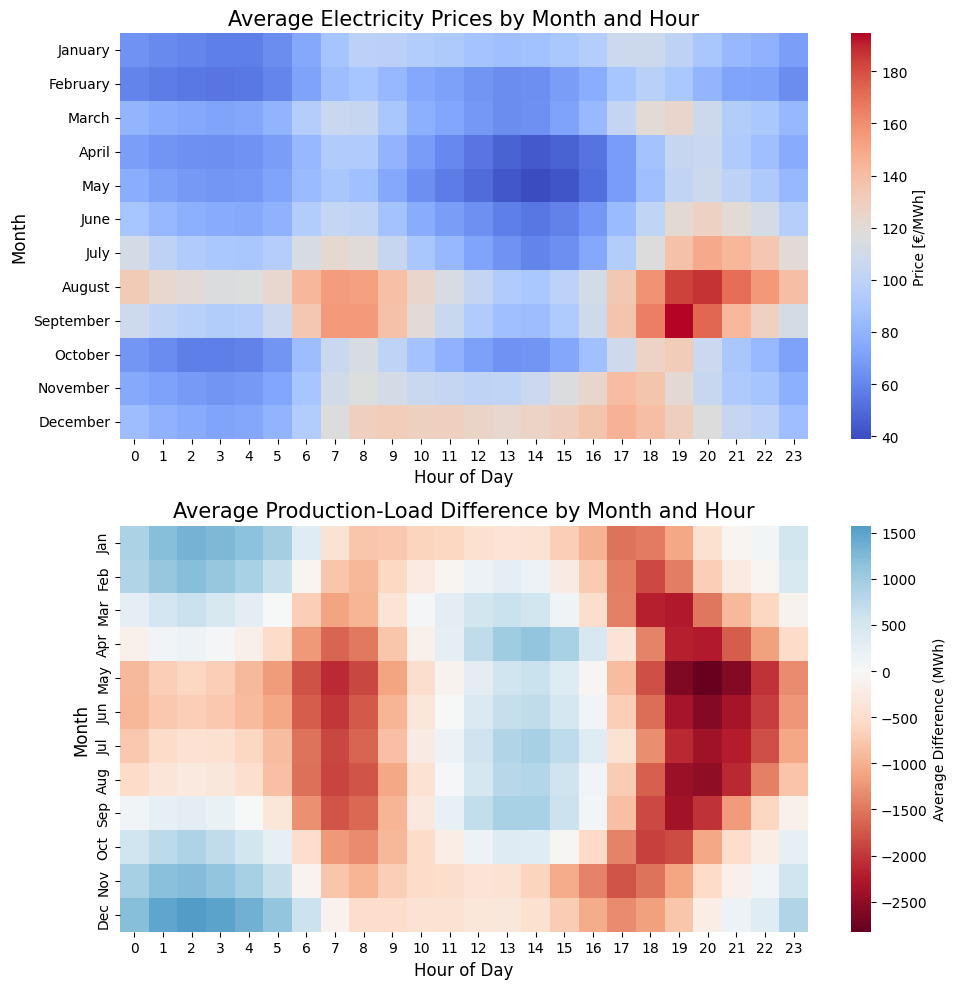

In [15]:
# Define the order of months
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

# Calculate average price for each month and hour
monthly_hourly_profile = combined_df.assign(
    month=combined_df['Datum von'].dt.month_name(),
    hour=combined_df['Datum von'].dt.hour
).groupby(['month', 'hour'])['Deutschland/Luxemburg [€/MWh] Originalauflösungen'].mean().unstack()

# Reorder months
monthly_hourly_profile = monthly_hourly_profile.reindex(index=months_order)

# Calculate total production (sum of all energy sources)
combined_df['Total Production'] = (
    combined_df['Wind Offshore [MWh] Originalauflösungen'] +
    combined_df['Wind Onshore [MWh] Originalauflösungen'] +
    combined_df['Photovoltaik [MWh] Originalauflösungen'] +
    combined_df['Wasserkraft [MWh] Originalauflösungen'] +
    combined_df['Biomasse [MWh] Originalauflösungen'] +
    combined_df['Kernenergie [MWh] Originalauflösungen'] +
    combined_df['Braunkohle [MWh] Originalauflösungen'] +
    combined_df['Steinkohle [MWh] Originalauflösungen'] +
    combined_df['Erdgas [MWh] Originalauflösungen']
)

# Calculate the difference between production and load
combined_df['Production_Load_Difference'] = combined_df['Total Production'] - combined_df['Gesamt (Netzlast) [MWh] Originalauflösungen']

# Calculate average hourly difference for each month
combined_df['Hour'] = combined_df['Datum von'].dt.hour
combined_df['Month'] = combined_df['Datum von'].dt.month

# Create pivot table for monthly-hourly averages
hourly_monthly_diff = pd.pivot_table(
    data=combined_df,
    values='Production_Load_Difference',
    index='Month',
    columns='Hour',
    aggfunc='mean'
)

# Create subplots for the two heatmaps
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# First heatmap: Average electricity prices by month and hour
sns.heatmap(
    monthly_hourly_profile, 
    cmap='coolwarm',
    xticklabels=range(24),
    yticklabels=months_order,
    cbar_kws={'label': 'Price [€/MWh]'},
    ax=axes[0]
)
axes[0].set_title('Average Electricity Prices by Month and Hour', fontsize=15)
axes[0].set_xlabel('Hour of Day', fontsize=12)
axes[0].set_ylabel('Month', fontsize=12)

# Second heatmap: Average production-load difference by month and hour
sns.heatmap(
    hourly_monthly_diff,
    cmap='RdBu',
    center=0,
    annot=False,
    cbar_kws={'label': 'Average Difference (MWh)'},
    xticklabels=range(24),
    yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    ax=axes[1]
)
axes[1].set_title('Average Production-Load Difference by Month and Hour', fontsize=15)
axes[1].set_xlabel('Hour of Day', fontsize=12)
axes[1].set_ylabel('Month', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()
